In [24]:
import numpy as np
import matplotlib.pyplot as plt

This note is to consider LP's reward problem in Uniswap V3 , where LP faces the problem that when he need to withdraw his lquidity from the pool to optimize the expected reward . Here we only focus on the stopping times that are the hitting time of some lower and upper boundaries of the pool price .  

First we define some model free functions which take as pool price path as input . Using these we can compute pool related quantities from input data . Next we generate the price paths by  SRW  and the no-arbitrage condition . Then the expected reward can be approximated by MC .

### Position & LP wealth part **(model free)**
This part computes LP's position ($X$ and $Y$ reserves) and LP's wealth . The position is given by
the following :

$$
(X , Y) = 
\begin{cases}
\big( L ( \sqrt{S^*} - \sqrt{P_a}) , L ( \frac{1}{\sqrt{S^*}} 
- \frac{ 1}{\sqrt{ P_b }}) \big) 
& \text{if} \; S^* \in [P_a , P_b ]
\\
\big( 0 , L ( \frac{1}{\sqrt{P_a}} - \frac{ 1}{\sqrt{ P_b}})
& \text{if} \; S^* < P_a
\\
\big( L ( \sqrt{P_b} - \sqrt{P_a}) , 0 \big)  
& \text{if} \; S^* > P_b
\end{cases}
$$

Parameters:
* ```P_a``` : LP's lower price range  boundary . 

* ```P_b``` : LP's upper price range  boundary .

* ```L``` : LP's liquidity in price range .

* ```S_p``` : current pool price .

Functions:
* ```position``` : return a tuple of amount of X and Y asset for the given pool price and LP price range .

* ```wealth``` : return the mark-to-market value of the tokens in LP's position .

In [11]:
def position(P_a,P_b,L,S_p):
    if S_p >= P_a and S_p <= P_b :    
        X = L * (np.sqrt(S_p) - np.sqrt(P_a) )
        Y = L * (1/np.sqrt(S_p) - 1/np.sqrt(P_b))
    elif S_p > P_b :
        X = L * (np.sqrt(P_b) - np.sqrt(P_a) )
        Y = 0
    elif S_p < P_a :
        X = 0
        Y = L * (1/np.sqrt(P_a) - 1/np.sqrt(P_b))
    return X,Y
def wealth(P_a,P_b,L,S_p , S_m):
    return position(P_a,P_b,L,S_p)[0]+ S_m*position(P_a,P_b,L,S_p)[1]

#### Plot LP's position
Fix $P_a = 2$ , $P_b = 10$ , $L = 5$ , we plot the  curve of LP's position . 

Text(0, 0.5, 'Y')

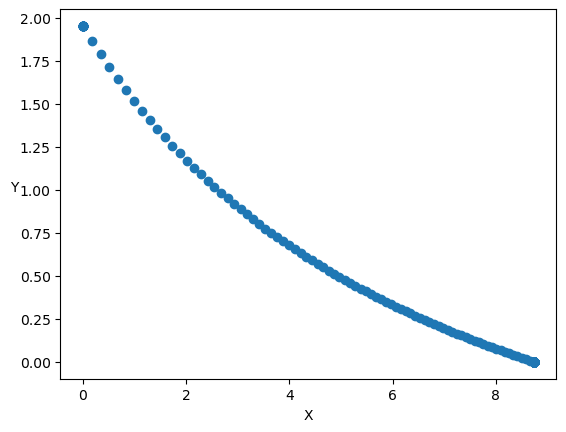

In [33]:
X =np.array( [position(2,10,5,s/10 )[0] for s in range(1,1000)] )
Y = np.array( [position(2,10,5,s/10 )[1] for s in range(1,1000)] )
plt.scatter( X , Y )
plt.xlabel("X")
plt.ylabel("Y" , rotation= 0)

#### Plot LP's wealth (pool price valued)
Here we plot the LP's wealth evaluted by the pool price instwad of the market price .

Text(0, 0.5, 'wealth')

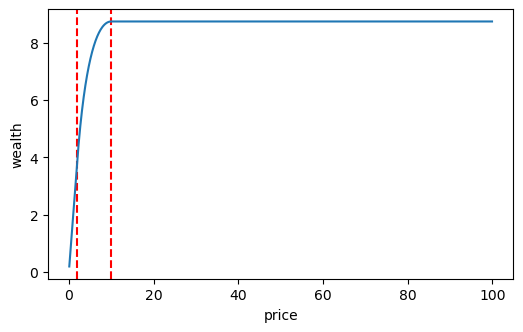

In [53]:
price_array = np.array( [s/10 for s in range(1,1000)] )
wealth_array = X + Y*price_array
plt.figure(figsize=(6,3.5))
plt.axvline(x=2,color='r',ls='--')
plt.axvline(x=10,color='r',ls='--')
plt.plot(price_array , wealth_array)
plt.xlabel("price")
plt.ylabel("wealth")

### Fee collection part **(model free)** 
This part computes the  fee  culmulated by LP over time ( w.r.t the given price paths) . Let 
$B_n = \ln S^*_n$ , how much fee earned at time $n+1$ is determined by $B_{n+1}$ and $B_n$ (pool price at time $n+1$ and $n$ ) as the following 

* $f_X(B_{n+1} , B_n) = L \frac{1-\gamma}{\gamma} \big( (P_b \wedge e^{B_{n+1}\;})^\frac{1}{2} \; - (P_a \vee e^{B_n })^\frac{1}{2} \; \big) I_{ \{ B_{n+1} \;> B_n \} \cap \{ B_n \; \leq \; \ln P_b\}} \quad $ is the fee paid in $X$ .

* $f_Y(B_{n+1} , B_n) = L \frac{1-\gamma}{\gamma} \big( (P_a \vee  e^{B_{n+1}\; })^{-\frac{1}{2}} \; - 
(P_b \wedge e^{B_n\;})^{-\frac{1}{2}} \; \big) I_{ \{ B_{n+1} \;< B_n \} \cap \{ B_n \; \geq \; \ln P_b\}}  \quad $ is the fee paid in $Y$ . 

Parameters:
* ```gamma``` : fee constant $\gamma \in  (0,1) $ . 

* ```S_p_array``` : pool price path .


Functions:
* ```fee_process``` : return a tuple of arrays consisting of the fee in $X$ and $Y$ earned at each moment from the given price path  .

In [13]:
def fee_process(P_a,P_b , gamma ,  L , S_p_array ) :
    # time 0 ~ T
    T = len(S_p_array) - 1
    fee_X , fee_Y = np.zeros((2 , T))
    
    for i in range(T):
        A = max(S_p_array[i] , P_a)
        B = min(S_p_array[i] , P_b)
        
        # fee from X asset (pool price up)
        if S_p_array[i] < P_b and S_p_array[i+1] > A  :

            fee_X[i] = L*(1-gamma)/gamma *( np.sqrt( min( S_p_array[i+1] , P_b) ) - np.sqrt( A ))

        # fee from Y asset (pool price down)        
        elif S_p_array[i] > P_a and S_p_array[i+1] < B :
            
            fee_Y[i] = L*(1-gamma)/gamma*( 1/np.sqrt( max( S_p_array[i+1] , P_a) ) - 1/np.sqrt( B ))
            
    return fee_X , fee_Y     

### Sample mean of LP's reward(model free)
This part computes the sample mean of LP's terminal reward (mark-to-market and discounted) from the input pool price paths collection .

Parameters:
* ```r``` : discounted interest rate .

* ```S_p_collection``` : a 2d-array consists of  pool price path samples . 

* ```S_m_collection``` : a 2d-array consists of  market price path samples . 

Functions:

* ```sample_mean_discounted_reward``` : return the averge discounted terminal reward of LP w.r.t the input collections of pool and market price paths . Here the terminal time the end time of the price path .

In [14]:
def sample_mean_discounted_reward( gamma , P_a , P_b , L , S_p_collection , S_m_collection ):
    sample_number = np.shape(S_p_collection)[0]
    value_array = np.zeros(sample_number)
    
    #run over all samples
    for i in range(sample_number):
        
        S_p_array = S_p_collection[i]
        S_m_array = S_m_collection[i]
        t_end = len(S_p_array)-1
        fee_X , fee_Y = fee_process(P_a,P_b , gamma ,  L , S_p_array)
        tokens = wealth(P_a,P_b,L, S_p_array[-1] , S_m_array[-1])
        reward_array[i]= np.exp(-r*t_end)*(fee_X[-1] + S_m_array[-1]*fee_Y[-1] + tokens)
            
    return np.average(reward_array) 

### Stopping at the boundary  **(model free)**
This part we consider the stopping time to be the moment that pool price path touches (or crosses ) the predetermined upper and lower boundaries .

Parameters :
* ```P_l``` : lower boundary price .

* ```P_u``` : upper boundary price .

Functions : 
* ```stop_bd_time``` : return the time that  pool price  path touches (or crosses ) the boundary . If this doesn't happen , return the end time instead .


In [15]:
def stop_bd_time(gamma , P_l , P_u , S_p_array , p):  
    length = len(S_p_array)

    for time in range(length) :
        if S_p_array[time] <= P_l or S_p_array[time] >= P_u :
            break
    return time

For the input price path data , we can now compute LP's position , token value ,  culmulative fee and average terminal reward .

### Pool price dynamic **(model free)**
Here we use the no-arbitrage condition to construct pool price dynamic w.r.t the input market price. When pool price deviates from the market price too much , there's a chance for arbitrage . In the presence of trading fee , arbitrageur may compare the profit he earns from the arbitrage and the fee he paid . The arbitrageur will maximize his profit and this will push the pool price to an optimal value as the following :

$$
S^*_\text{optimal} = \begin{cases}
    \gamma^{-1} S & \text{if} \; S^* > \gamma^{-1} S \\
     S^* & \text{if} \; S^* \in [\gamma S , \gamma^{-1} S ] \\
    \gamma S & \text{if} \; S^* < \gamma S
\end{cases}
$$

Parameters:

* ```gamma``` :  fee constant  $ \gamma \in (0,1) $  . 
* ```S_p_ini``` : initial pool price .
* ```S_m_array``` : initial market price .

Functions:
* ```pool_process``` : return an array of  pool price by the no-arbitrage condition with the length that equals to the input market price path .

In [20]:
def pool_process( gamma , S_p_ini , S_m_array ):
    length = len(S_m_array)
    S_p_array = np.zeros(length)
    S_p_array[0]= S_p_ini
    
    for time in range(1,length):
            
        if S_m_array[time] >  S_p_array[time-1]*gamma**(-1) :

            S_p_array[time] =  S_m_array[time]*gamma

        elif S_m_array[time]  < S_p_array[time-1]*gamma:

            S_p_array[time] =  S_m_array[time]*gamma**(-1)

        else:
             S_p_array[time] =  S_p_array[time-1]
    return S_p_array 

### Market price model (model based)
Here we assume the market price follows geometric simple random walk and define a function that
generates the path .

Parameters:
* ```p``` : forward probability of the random walk . 
* ```delta``` : step size of the random walk .
* ```T``` : the end time of the generated price process .
* ```S_m_ini``` : initial market price .

Functions:
* ```market_process``` : return an array of market price generated by a random walk with length $T+1$ and the given initial price .

In [17]:
def market_process( T , p ,delta , S_m_ini):
    S_m_array = np.zeros(T+1)
    S_m_array[0] = S_m_ini
    for time in range(1,T+1):
        U = np.random.rand()
        if U < p :
            S_m_array[time] = S_m_array[time-1]*np.exp(delta)
        else:
            S_m_array[time] = S_m_array[time-1]*np.exp(-delta)
            
    return S_m_array

#### Plot the price path
Here is an example of a pool price path which is induced by a market price path . This market price
path is a realization of RW with $p = 0.5$ , $\delta = 10^{-3}$ . We choose fee constant $\gamma$  to be $0.997$ corresponding to the typical fee ratio $0.3 \%$ . The market upper in the graph corresponds to $\gamma^{-1}S_n$ and the lower corresponds to $\gamma S_n$ .

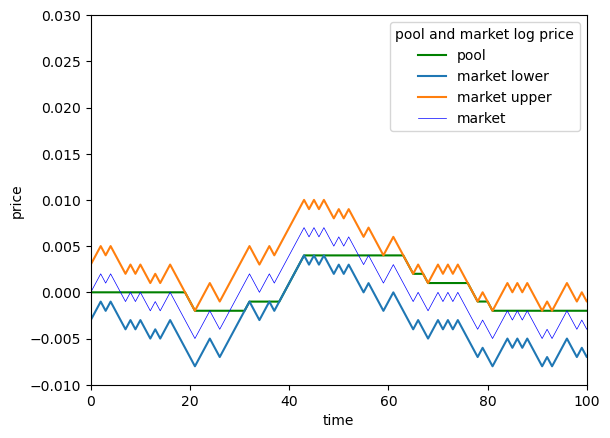

In [21]:
delta = 10**(-3)
gamma = 0.997

# Total run time should be as large as possible
T= 1000

S_m_array = market_process( T , 0.5 , delta , 1)

S_p_array = pool_process( gamma ,1 ,S_m_array)

T_array=np.arange(T+1)

plt.figure()
plt.plot(T_array, np.log(S_p_array) ,'g' , label='pool')
plt.plot(T_array, np.log(gamma*S_m_array) , label='market lower')
plt.plot(T_array, np.log(S_m_array*(gamma**-1))  , label='market upper' )
plt.plot(T_array, np.log(S_m_array) , 'b',linewidth=0.5 , label='market')
plt.legend(title="pool and market log price")
plt.xlabel("time")
plt.ylabel("price")
plt.xlim(0,100)
plt.ylim(-0.01,0.03)
plt.show()

### Expected reward stopped at boundary **(model based)**
This part uses random walk  to generate path samples that and compute expected reward stopped at boundary  (truncated with  terminal time $t_{end}$ ,input data's length) , i.e

$$ 
E_{(S^*_{ini}\;  , \;S_{ini} \;) }( e^{-r T  \wedge t_{ end} \;} W_{  T \wedge t_{end} \;} 
+ \sum_{n=1}^{T \wedge t_{end}} e^{-rn} [f_X( S^*_{n} , S^*_{n-1}) + 
e^{ S^*_{n} \; + M_{n} \; \delta} f_Y( S^*_{n} , S^*_{n-1})  ] 
$$
by Monte-Carol . 

Parameters:
* ```ln_P_a``` : logarithm of lower price $P_a$ of LP's price range. 
* ```ln_P_b``` : logarithm of upper price $P_b$ of LP's price range. 
* ```ln_P_l``` : logarithm of lower price $P_l$ of stopping levels. 
* ```ln_P_u``` : logarithm of upper price $P_u$ of stopping levels. 
* ```ln_S_p_ini``` : logarithm of initial pool price . 
* ```ln_S_m_ini``` : logarithm of initial market price . 
* ```t_end``` : constant terminal time of the price path .

Functions:
* ```exp_discounted_norm_reward_bd``` : return the  normalized expected discounted reward (approximated)  starting from the given initial price and stopped at the boundary or terminal time  . 

* ```exp_discounted_reward_bd_array``` : return an array of  expected discounted wealth (approximated)  starting from the indexed states (see "Bellman equation.ipynb") and stopped at the boundary . One can skip this part .

* ```plot_enum_rate``` : plot the expected discounted reward (y-axis) w.r.t the enumeration index (x-axis) with the given parameters and the default interest rates.

In [23]:
def exp_discounted_norm_reward_bd( ln_P_a, ln_P_b , ln_P_l , ln_P_u  , ln_S_p_ini , ln_S_m_ini , L ,gamma ,t_end, delta , r, p):

    P_a, P_b , P_l , P_u , S_p_ini , S_m_ini = np.exp( np.array([ln_P_a, ln_P_b ,  ln_P_l , ln_P_u  , ln_S_p_ini , ln_S_m_ini])*delta )
    
    #collection of paths
    S_p_collection , S_m_collection = np.empty((2,10**3) , dtype='object')
    
    #generate paths (10**3 samples)
    for i in range(10**3):
        S_m_array = market_process(  t_end , p ,delta , S_m_ini)
        S_p_array = pool_process( t_end , p  , gamma , S_p_ini , S_m_array )
        tau = stop_bd_time(gamma , P_l , P_u , S_p_array , p)
       
        #store the truncated path
        S_p_collection[i] = S_p_array[:tau+1]
        S_m_collection[i] = S_m_array[:tau+1]
    V = sample_mean_discounted_reward(r, gamma , P_a , P_b ,L, S_p_collection , S_m_collection )
    V_norm = V/position_value(P_a,P_b,L, S_p_ini , S_m_ini)
    return V_norm

The following is to compare with the result from Bellman equation (can be skipped)

In [191]:
def exp_discounted_reward_bd_array(ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma , k , r , p):
    N = ln_Pu - ln_Pl - 1
    V_0 = np.zeros(2*N+2)
    t_end = 10**6
    for n in range(2*N+2):
        print("index " , n)
        if n <= N :
            V_0[n] = exp_discounted_reward_bd(ln_Pa, ln_Pb , ln_Pl , ln_Pu  , n+ln_Pl , n+ln_Pl-k , L ,gamma , t_end,k ,r , p)
        elif n >= N+1 :
            V_0[n] = exp_discounted_reward_bd(ln_Pa, ln_Pb , ln_Pl , ln_Pu  , n+ln_Pl-N , n-N+ln_Pl+k , L ,gamma ,t_end,k , r , p)
    return V_0


#result with different interest rate
def plot_enum_rate(k, ln_Pa, ln_Pb , ln_Pl , ln_Pu , L , gamma  , p):
    
    r_array = [0,10**(-6),5*10**(-5),10**(-5),10**(-4),10**(-3),5*10**(-3),5*10**(-2),1]
    N = ln_Pu - ln_Pl -1
    
    fig , ax =plt.subplots(3,3)

    for i in range( len(r_array) ):
        r = r_array[i]
        V_array = exp_discounted_reward_bd_array(ln_Pa, ln_Pb , ln_Pl , ln_Pu  , L ,gamma ,k, r , p)
        j_1 = int(i/3)
        j_2 = i%3
        ax[j_1,j_2].bar(np.arange(2*N+2), V_array  )
        ax[j_1,j_2].set_xlabel("time")
        ax[j_1,j_2].set_ylabel("value")
        ax[j_1,j_2].set_title( "r="+str(r) )
    plt.tight_layout()
    

### Loss versus rebalancing (LVR)
In the following we introduce a rebalancing strategy $\{(X^R_n , Y^R_n)\}_{n \geq 0}$ that outperforms the LP's asset value : 
At the begin , the initial position is $(X^R_0 , Y^R_0) \equiv (X_0 , Y_0)$ (same as LP's initial
position) . Then we require the process   satisfying for all $n\geq 0$  :

1. risky asset replication : $Y^R_n = Y_n$
2. self-financing : $  V_{n+1} - V_n =  S_{n+1} Y^R_n - S_{n} Y^R_n \quad$  where $V_n \equiv X^R_{n} + S_n Y^R_{n}$ is the portfolio value of the strategy .

In other words , this strategy maintains the same amount of risky asset $Y$ as LP by trading with the market and
it must be self-financing (in the discounted sense). Note that 
$$
\begin{align*}
V_n &= V_0 + \sum^n_{m=1} Y_{m-1} (  S_m - S_{m-1}) \\
\Rightarrow 
X^R_n &= \big\{ V_0 + \sum^n_{m=1} Y_{m-1} ( S_m - S_{m-1}) \big\} - S_n Y_n  
\end{align*}
$$

It's not diffcult to show that the rebalancing strategy outperforms , i.e $ V_n \geq  W_n \equiv X_n + S_n Y_n $ , which implies $X^R_n \geq X_n \geq 0 $ . So it's indeed an admissible strategy .  

Functions:
* ```position_R``` : return a tuple-array consists of the rebalancing position w.r.t the input pool price and market price paths .  

In [131]:
def position_R(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array):
    length = len(S_p_array)
    X_R = np.zeros(length)
    
    X_R[0] = position(P_a,P_b,L,S_p_array[0])[0]
    
    # Y_R equals to the amount of Y in LP's position
    Y_R = np.array( [position(P_a,P_b,L,S_p_array[time])[1] for time in range(length)] )
    V_0 = X_R[0] + S_p_array[0]*Y_R[0]
    sum = 0
    for time in range(1,length):
        sum+= Y_R[time-1]*(np.exp(-time*r)*S_m_array[time] - np.exp(-(time-1)*r)*S_m_array[time-1])
        X_R[time] = np.exp(time*r)*( V_0 + sum ) - S_m_array[time] * Y_R[time]
    return X_R , Y_R

def position_R_value(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array):
    X_R = position_R(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array)[0]
    Y_R = position_R(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array)[1]
    
    return  X_R + S_m_array*Y_R

We can plot the result to compare $V_n$ and $W_n$ ($r=0$ case) for different value of $p$

In [180]:
gamma = 0.997
k=10
delta = -np.log(gamma)/k
T = 10**5
r=0
P_a = np.exp(-5*delta)
P_b = np.exp(5*delta)
p = [0.4 , 0.5 , 0.6]
V = np.empty( 3 , dtype =object)
W = np.empty( 3 , dtype =object)

for i in range(3):
    S_p_array , S_m_array = pool_process( T , p[i]  , delta , gamma )
    X_R ,Y_R= position_R(r , P_a , P_b , gamma ,  1 , S_p_array , S_m_array)
    V[i] = position_R_value(r ,P_a,P_b , gamma ,  1 , S_p_array , S_m_array)
    W[i] = np.array([asset_value(P_a,P_b,1,S_p_array[time] , S_m_array[time] ) for time in range(T+1)  ])
    

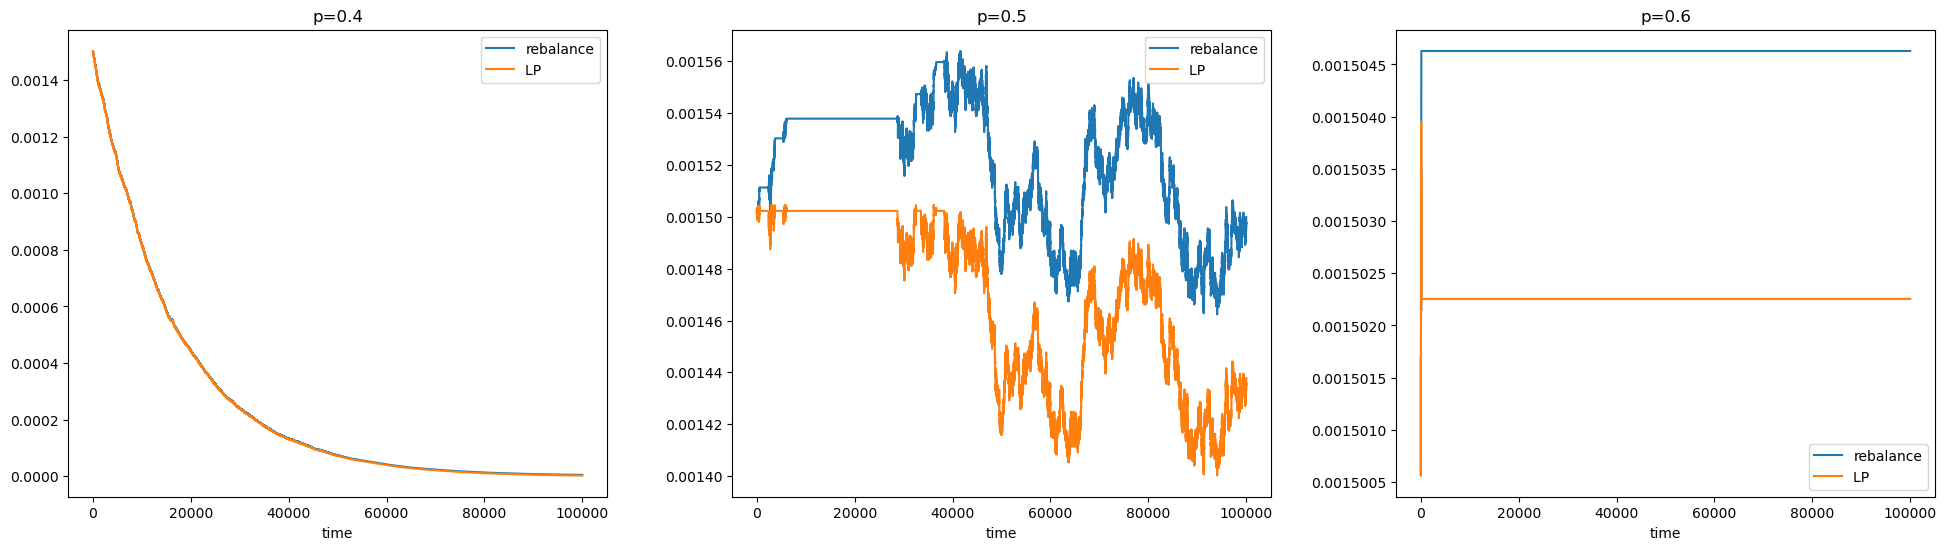

In [181]:
fig , ax = plt.subplots(1,3 , figsize =(20,6))
for i in range(3):
    ax[i].plot(V[i] , label = "rebalance")
    ax[i].plot(W[i] , label = "LP ")
    ax[i].legend()
    ax[i].set_xlabel("time")
    ax[i].set_title("p="+str(p[i]))
plt.tight_layout(pad=2.5)    

For $p=0.4$ case , the curves almost overlap . Define the **Loss versus rebalancing** to be the difference $\mathbf{LVR}_n \equiv V_n - W_n = X^R_n - X_n$ and we plot it in the following:  

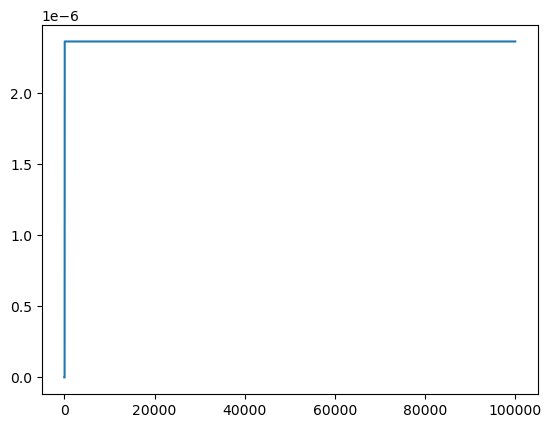

In [182]:
plt.plot(V[0]-W[0])

Now we can try to use this rebalancing portfolio as bechmark to evaluate the LP'position (fee plus asset value) . 

If the fee part can cover this oppurtinuity cost , then the LP's position is worthy , otherwise it's not a good investment .

In [183]:
def LVR(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array):
    length = len(S_p_array)
    X_R ,Y_R= position_R(r , P_a , P_b , gamma ,  L , S_p_array , S_m_array)
    W = np.array([asset_value(P_a,P_b, L ,S_p_array[time] , S_m_array[time] ) for time in range(length)  ])
    V = position_R_value(r ,P_a,P_b , gamma ,  L , S_p_array , S_m_array)
    return V-W